# Examining Racial Discrimination in the US Job Market

### Background
Racial discrimination continues to be pervasive in cultures throughout the world. Researchers examined the level of racial discrimination in the United States labor market by randomly assigning identical résumés to black-sounding or white-sounding names and observing the impact on requests for interviews from employers.

### Data
In the dataset provided, each row represents a resume. The 'race' column has two values, 'b' and 'w', indicating black-sounding and white-sounding. The column 'call' has two values, 1 and 0, indicating whether the resume received a call from employers or not.

Note that the 'b' and 'w' values in race are assigned randomly to the resumes when presented to the employer.

### Exercises
You will perform a statistical analysis to establish whether race has a significant impact on the rate of callbacks for resumes.

Answer the following questions **in this notebook below and submit to your Github account**. 

   1. What test is appropriate for this problem? Does CLT apply?
   2. What are the null and alternate hypotheses?
   3. Compute margin of error, confidence interval, and p-value. Try using both the bootstrapping and the frequentist statistical approaches.
   4. Write a story describing the statistical significance in the context or the original problem.
   5. Does your analysis mean that race/name is the most important factor in callback success? Why or why not? If not, how would you amend your analysis?

You can include written notes in notebook cells using Markdown: 
   - In the control panel at the top, choose Cell > Cell Type > Markdown
   - Markdown syntax: http://nestacms.com/docs/creating-content/markdown-cheat-sheet


#### Resources
+ Experiment information and data source: http://www.povertyactionlab.org/evaluation/discrimination-job-market-united-states
+ Scipy statistical methods: http://docs.scipy.org/doc/scipy/reference/stats.html 
+ Markdown syntax: http://nestacms.com/docs/creating-content/markdown-cheat-sheet
+ Formulas for the Bernoulli distribution: https://en.wikipedia.org/wiki/Bernoulli_distribution

In [28]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
%matplotlib inline 
import seaborn as sns
np.random.seed(42)
sns.set()
import warnings
warnings.filterwarnings('ignore')

In [29]:
data = pd.io.stata.read_stata('data/us_job_market_discrimination.dta')

In [30]:
# number of callbacks for black-sounding names
print(sum(data[data.race=='b'].call))

#
print(data.shape)

157.0
(4870, 65)


In [31]:
data.head()

,id,ad,education,ofjobs,yearsexp,honors,volunteer,military,empholes,occupspecific,...,compreq,orgreq,manuf,transcom,bankreal,trade,busservice,othservice,missind,ownership
0,b,1,4,2,6,0,0,0,1,17,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,
1,b,1,3,3,6,0,1,1,0,316,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,
2,b,1,4,1,6,0,0,0,0,19,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,
3,b,1,3,4,6,0,1,0,1,313,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,
4,b,1,3,3,22,0,0,0,0,313,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,Nonprofit


In [32]:
data.columns

Index(['id', 'ad', 'education', 'ofjobs', 'yearsexp', 'honors', 'volunteer',
       'military', 'empholes', 'occupspecific', 'occupbroad', 'workinschool',
       'email', 'computerskills', 'specialskills', 'firstname', 'sex', 'race',
       'h', 'l', 'call', 'city', 'kind', 'adid', 'fracblack', 'fracwhite',
       'lmedhhinc', 'fracdropout', 'fraccolp', 'linc', 'col', 'expminreq',
       'schoolreq', 'eoe', 'parent_sales', 'parent_emp', 'branch_sales',
       'branch_emp', 'fed', 'fracblack_empzip', 'fracwhite_empzip',
       'lmedhhinc_empzip', 'fracdropout_empzip', 'fraccolp_empzip',
       'linc_empzip', 'manager', 'supervisor', 'secretary', 'offsupport',
       'salesrep', 'retailsales', 'req', 'expreq', 'comreq', 'educreq',
       'compreq', 'orgreq', 'manuf', 'transcom', 'bankreal', 'trade',
       'busservice', 'othservice', 'missind', 'ownership'],
      dtype='object')

<div class="span5 alert alert-success">
<p>Your answers to Q1 and Q2 here</p>
</div>

In [33]:
w = data[data.race=='w']
b = data[data.race=='b']
w_call = w.call
b_call = b.call
print(w.shape, b.shape)
print(np.sum(w_call), np.sum(b_call))

(2435, 65) (2435, 65)
235.0 157.0


## Question 1 and 2: What test is appropriate for this problem? Does CLT apply?, What are the null and alternate hypotheses?

For this project, I will be conducting a $z$ test as opposed to a $t$ test. The reasoning behind this is that since we are comparing the statistics of the sample proportions, we can immediately rule out using the $t$ test. To check if the central limit theorem applies, we compare our sample size to see if it is above 30. This indeed holds true, with a total sample size of 4870. Here, we will now state our hypothesis (denoted by $H_{0}$ and $H_{a}$ for the null and alternative hypotheses respectively:
* $H_{0} =$ There is no effect on whether or not a candidate will recieve a callback from the employer based off the candidate's name's perceived blackness or whiteness. 
* $H_{a} =$ There is an effect on whether or not a candidate will recieve a callback from the employer based off the candidate's name's perceived blackness or whiteness. 

For the remainder of this project, I will be computing a confidence interval of 95% and comparing against an alpha value of .05.

<div class="span5 alert alert-success">
<p>Your answers to Q3 here</p>
</div>

## Question 3: Compute margin of error, confidence interval, and p-value. Try using both the bootstrapping and the frequentist statistical approaches.

### Bootstrapping Approach:

In [34]:
# Define bootstrap replicates function
def draw_bs_reps(data, func, size = 1):
    bs_replicates = np.empty(size)
    for i in range(size):
        bs_replicates[i] = func(np.random.choice(data, size=len(data)))
    return bs_replicates

# Compute the difference of the sample means
mean_diff = np.mean(w_call) - np.mean(b_call)

# Generate bootstrap replicates of the means
bs_reps_white = draw_bs_reps(w_call, np.mean, size = 10000)
bs_reps_black = draw_bs_reps(b_call, np.mean, size = 10000)

# Compute the samples of difference of means
bs_diff_reps = bs_reps_white - bs_reps_black

# Compute a 95% confidence interval
conf_int = np.percentile(bs_diff_reps, [2.5, 97.5])

# Looking up a z-table, we find that for a 95% confidence interval we get a value of z = 1.96
z = 1.96

print('Difference of means =', mean_diff)
print('95% confidence interval =', conf_int)
print('Margin of error =', z * np.std(bs_diff_reps))

Difference of means = 0.03203285485506058
95% confidence interval = [0.01683778 0.04722793]
Margin of error = 0.015152539488055559


In [35]:
# Now let's conduct a hypothesis test for the null hypothesis: That is, we expect the differences of the mean to be 0. 
# We start by shifting the samples so that intial data sets have the same mean.
combined_mean = np.mean(np.concatenate((w_call, b_call)))
w_call_shifted = w_call - np.mean(w_call) + combined_mean
b_call_shifted = b_call - np.mean(b_call) + combined_mean

# Generate bootstrap replicates of shifted data sets
bs_reps_white_shifted = draw_bs_reps(w_call_shifted, np.mean, size = 100000)
bs_reps_black_shifted = draw_bs_reps(b_call_shifted, np.mean, size = 100000)

# Compute the samples of difference of means
bs_diff_reps_shifted = bs_reps_white_shifted - bs_reps_black_shifted

# Compute the p-value
p = np.sum(bs_diff_reps_shifted >= mean_diff) / len(bs_diff_reps_shifted)

print("p = ", p)

p =  3e-05


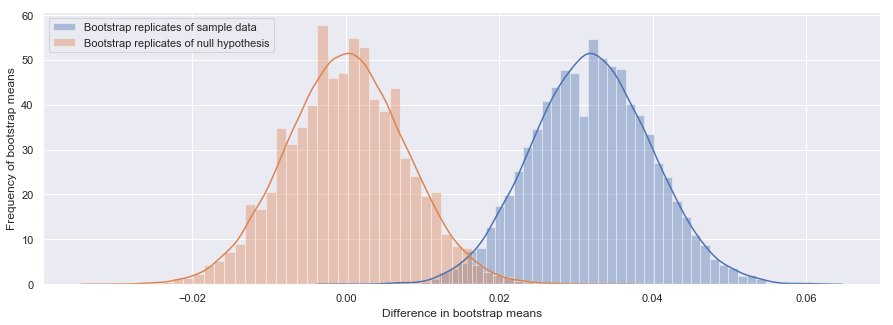

In [36]:
# For good measure, let's also graph these the two distributions of the bootstrap replicates against each other.
_ = plt.figure(figsize = (15, 5))
_ = sns.distplot(bs_diff_reps, bins = 50, label = "Bootstrap replicates of sample data")
_ = sns.distplot(bs_diff_reps_shifted, bins = 50, label = "Bootstrap replicates of null hypothesis")
_ = plt.xlabel("Difference in bootstrap means")
_ = plt.ylabel("Frequency of bootstrap means")
_ = plt.legend(loc = "upper left")
plt.show()

### Frequentist Approach:

In [37]:
# Let's start by calculating some values from our datasets that will be useful in testing our hypothesis
n = 2435
w_mean = sum(w_call)/n
b_mean = sum(b_call)/n
mean_diff = w_mean - b_mean
print(w_mean, b_mean, mean_diff)

0.09650924024640657 0.06447638603696099 0.032032854209445585


In [38]:
# Now let's calculate the necessary values: The margin of error, the 95% confidence interval and the p-value
# Since our sample size is large, we can estimate our standard deviation using the sample data
std_mean_diff = np.sqrt(((w_mean*(1-w_mean))/n) + ((b_mean*(1-b_mean))/n))

# Our margin of error would then be this value multiplied by our pulled z value (same as the value from the bootstrap method)
d = z * std_mean_diff

print('Difference of means =', mean_diff)
print('95% confidence interval =', [mean_diff - d, mean_diff + d])
print('Margin of error =', d)

Difference of means = 0.032032854209445585
95% confidence interval = [0.016777447859559147, 0.047288260559332024]
Margin of error = 0.015255406349886438


In [39]:
# As above, let's now conduct a hypothesis test for the null hypothesis: That is, we expect the differences of the mean to be 0.
# Assuming our null hypothesis is true, let's calculate the corresponding z score.
# Start by calculating the new standard deviation of the sampling distribution assuming the null hypothesis is correct. 
p = (sum(w_call)+sum(b_call)) / (2 * n)
std_null = np.sqrt((2/n)*(p*(1-p)))

# Now we have enough information to calculate our new z score.
z_null = (mean_diff - 0) / std_null
print(z_null)

4.108412152434346


In [40]:
# I was not able to find a table containing a z-score this high, so I used an online calculator for a 2-tailed test which gives:
p = 4.1E-05
print("p = ", p)

p =  4.1e-05


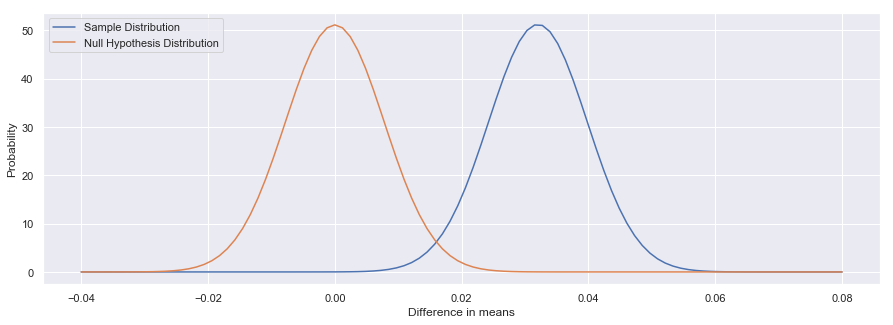

In [41]:
# As above, let's utilize the data we've calculated to draw some simple probability distribution curves

x = np.linspace(-.04, .08, 100)
y_sample = stats.norm.pdf(x, mean_diff, std_mean_diff) # the sample distribution
y_null = stats.norm.pdf(x, 0, std_null) #the null hypothesis distribution
_ = plt.figure(figsize = (15, 5))
_ = plt.plot(x, y_sample, label='Sample Distribution')
_ = plt.plot(x, y_null, label='Null Hypothesis Distribution')
_ = plt.xlabel("Difference in means")
_ = plt.ylabel("Probability")
_ = plt.legend(loc = "upper left");
plt.show()

<div class="span5 alert alert-success">
<p> Your answers to Q4 and Q5 here </p>
</div>

## Questions 4 and 5: Write a story describing the statistical significance in the context of the original problem. Does your analysis mean that race/name is the most important factor in callback success? Why or why not? If not, how would you amend your analysis?

From both the bootstrap method and the frequentist approach, we can see that whether or not a candidate has a percieved white or black name *is* statistically significant. Therefore we reject the null hypothesis. In the bootstrap method, we see that even with a simulated sample size of over 100000 data points we only get a .003% chance that the bootstrapped data matches with our null hypothesis. In fact, when I originally completed this exercise I only used sample sizes of 10000, but that wasn't enough to capture even a single occurance that fits the null hypothesis. A similar story is told from using the frequentist data. Given a p-value of 4.1e-5, it means we only have a .0041% chance that the sample data we collected fits with the null hypothesis. Knowing this, a cursory look at the mean difference values between our sample data could've given us a similar conclusion. With mean values of 0.096 and 0.064 for white callbacks and black callbacks respectively, we see that candidates with white-sounding names have 1.5 times the call back rate compared to candidates with black-sounding names. 

This is however, not a complete analysis. Looking at our dataframe, we note that there are 64 columns not including the call back column, all of which could have a strong correlation between them and getting a call back. Therefore the statement that race is the most important factor in callback success cannot be confirmed. To amend my analysis, I would instead draw a correlation heatmap between selected columns that make sense with regard to playing a factor in callback success and repeat the above analysis for each column.